# Project Based Learning Deep Learning - Generate Wajah Anime Menggunakan Deep Convolutional Generative Adversarial Network (DCGAN)

**Deskripsi Proyek**

Proyek ini memanfaatkan Deep Convolutional Generative Adversarial Network (DCGAN) untuk menghasilkan citra wajah anime secara otomatis melalui kompetisi antara dua komponen utama, yaitu generator dan discriminator. Generator bertugas menciptakan gambar wajah anime baru, sementara discriminator berusaha membedakan antara gambar asli dan gambar hasil generasi.

Selain membangun dan melatih model, proyek ini juga mengeksplorasi pengaruh kombinasi hyperparameter, seperti learning rate dan nilai beta₁ dengan menggunakan pendekatan grid search untuk mencari konfigurasi yang paling efektif. Dengan demikian, proyek ini tidak hanya berfokus pada kualitas visual gambar anime yang dihasilkan, tetapi juga pada pemahaman bagaimana pengaturan parameter dalam deep learning memengaruhi kinerja dan stabilitas model generatif.

# Instalasi & Import Library

In [ ]:
# library kagglehub
!pip install -q kagglehub

import kagglehub # library untuk download dataset dari Kaggle
import tensorflow as tf # tensorflow sebagai framework utama
from tensorflow import keras
from tensorflow.keras import layers # modul layers untuk membangun arsitektur neural network
from tensorflow.keras.models import Sequential # sequential untuk model layer berurutan

# jenis layer dalam DCGAN
from tensorflow.keras.layers import (
    Conv2D,              # convolution 2D untuk discriminator
    MaxPooling2D,        # max pooling
    Dense,               # fully connected layer
    Flatten,             # mengubah feature map menjadi vektor 1D
    Conv2DTranspose,     # transposed conv untuk upsampling di generator
    Reshape,             # mengubah bentuk tensor, misalnya vektor -> feature map
    ReLU,                # aktivasi ReLU
    LeakyReLU,           # aktivasi LeakyReLU
    BatchNormalization,  # batchnorm untuk menstabilkan training
    Dropout              # dropout untuk regularisasi
)

from tensorflow.keras.optimizers import Adam # optimizer Adam untuk update bobot generator & discriminator
from tensorflow.keras.losses import BinaryCrossentropy # loss function binary cross entropy untuk GAN
import matplotlib.pyplot as plt # matplotlib untuk visualisasi gambar dan grafik loss
import numpy as np # numpy untuk operasi numerik
import pandas as pd # pandas untuk menyimpan dan menganalisis hasil eksperimen
import os # os untuk operasi terkait sistem file
import random # random untuk hyperparameter tuning

print("Versi TensorFlow:", tf.__version__)
print("Jumlah GPU Tersedia : ", len(tf.config.list_physical_devices('GPU')))

Versi TensorFlow: 2.19.0
Jumlah GPU Tersedia :  1


# Download & Load Dataset

In [ ]:
# download dataset kaggle menggunakan kagglehub
path = kagglehub.dataset_download("splcher/animefacedataset")
print("Path File Dataset:", path)

# parameter gambar yang akan digunakan sebagai ukuran input model
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64 # batch size standar untuk dcgan
LATENT_DIM = 300 # dimensi vektor noise (latent space) yang masuk ke generator

# load dataset dari direktori hasil download
# menggunakan image_dataset_from_directory karena lebih efisien di memori
dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode=None,       # tidak butuh label karena ini tugas gan (unsupervised)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# normalisasi piksel ke range [0, 1] karena generator menggunakan sigmoid di output
# jika nantinya generator diganti ke tanh, normalisasi harus diubah ke [-1, 1]
normalization_layer = layers.Rescaling(1./255)

# optimasi performa pipeline data dengan map, cache, dan prefetch
dataset = dataset.map(lambda x: normalization_layer(x))           # terapkan normalisasi ke setiap batch
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE) # caching + prefetch untuk mempercepat input pipeline

print("Dataset Siap Digunakan.")

Using Colab cache for faster access to the 'animefacedataset' dataset.
Path File Dataset: /kaggle/input/animefacedataset
Found 63565 files.
Dataset Siap Digunakan.


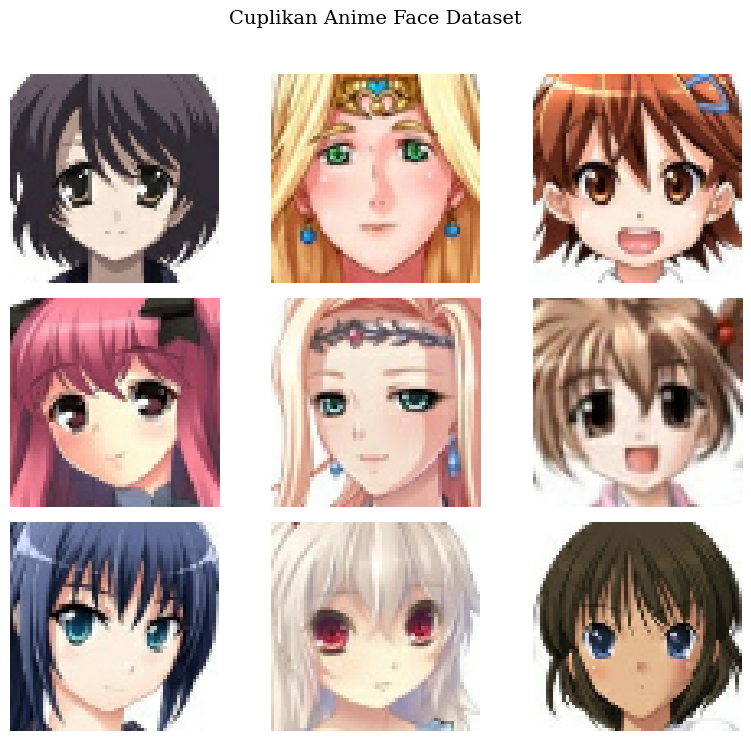

In [ ]:
# preview beberapa sampel dataset
plt.rcParams["font.family"] = "serif"

plt.figure(figsize=(8, 8))

# ambil satu batch
for batch in dataset.take(1):
    images = batch.numpy()

# tampilkan 9 gambar pertama
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

# atur judul dan jaraknya
plt.suptitle("Cuplikan Anime Face Dataset", fontsize=14, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# Arsitektur Modelling DCGAN

In [ ]:
# build generator
def build_generator():
    model = Sequential(name="Generator")

    # input, random noise (latent vector)
    # dimulai dengan dense layer yang di-reshape ke 8x8x512
    model.add(Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    model.add(ReLU())

    # ubah vektor 1d menjadi feature map berukuran 8x8 dengan 512 channel
    model.add(Reshape((8, 8, 512)))

    # upsampling ke resolusi 16x16
    model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(ReLU())

    # upsampling ke 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(ReLU())

    # upsampling ke 64x64
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(ReLU())

    # output layer, menghasilkan citra 64x64x3 (rgb)
    # aktivasi sigmoid karena data dinormalisasi ke [0, 1]
    model.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))

    return model


# build discriminator
def build_discriminator():
    model = Sequential(name="Discriminator")

    # input image, citra 64x64x3
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample ke 32x32 menggunakan max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ekstraksi fitur lanjutan dan downsample ke 16x16
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ekstraksi fitur lebih dalam dan downsample ke 8x8
    model.add(Conv2D(256, kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ubah feature map menjadi vektor 1d
    model.add(Flatten())
    # dense layer sebagai lapisan fitur tinggi sebelum output
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    # output layer, probabilitas real vs fake (1 neuron dengan sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    return model

# build instance generator dan discriminator
generator = build_generator()
discriminator = build_discriminator()

print("Model Berhasil Dibuat.")

# menampilkan ringkasan arsitektur generator
print("Arsitektur Generator.")
generator.summary()

# menampilkan ringkasan arsitektur discriminator
print("Arsitektur Discriminator")
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Berhasil Dibuat.
Arsitektur Generator.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     9,863,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

Arsitektur Discriminator


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,730,625 (10.42 MB)

 Trainable params: 2,730,625 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

# Class DCGAN & Compile

In [ ]:
# class dcgan
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        # memanggil konstruktor kelas induk (keras.model)
        super().__init__()
        # menyimpan referensi ke generator dan discriminator
        self.generator = generator
        self.discriminator = discriminator
        # menyimpan dimensi vektor noise (latent space)
        self.latent_dim = latent_dim

        # trackers untuk menyimpan nilai rata-rata loss generator dan discriminator
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        # daftar metric yang akan di-reset otomatis setiap epoch oleh keras
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        # memanggil compile bawaan keras.model
        super(DCGAN, self).compile()
        # menyimpan optimizer untuk generator dan discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        # menyimpan fungsi loss yang digunakan (binary crossentropy)
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # train discriminator
        # mengambil ukuran batch dari tensor real_images
        batch_size = tf.shape(real_images)[0]
        # membuat noise acak sebagai input generator
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            # generate fake images dari generator
            fake_images = self.generator(random_noise, training=True)

            # prediksi discriminator pada gambar asli dan palsu
            pred_real = self.discriminator(real_images, training=True)
            pred_fake = self.discriminator(fake_images, training=True)

            # label: real = 1, fake = 0 (dengan smoothing pada label real)
            real_labels = tf.ones((batch_size, 1))
            # label smoothing ringan agar discriminator tidak terlalu percaya diri
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            fake_labels = tf.zeros((batch_size, 1))

            # hitung loss untuk real dan fake
            d_loss_real = self.loss_fn(real_labels, pred_real)
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            # loss total discriminator adalah rata-rata keduanya
            d_loss = (d_loss_real + d_loss_fake) / 2

        # update bobot discriminator berdasarkan gradien
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # train generator
        with tf.GradientTape() as tape:
            # generate batch baru fake images dari noise
            random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_images = self.generator(random_noise, training=True)

            # discriminator menilai fake images ini
            pred_fake = self.discriminator(fake_images, training=True)
            # generator ingin discriminator menganggap fake sebagai real (label = 1)
            misleading_labels = tf.ones((batch_size, 1))

            # loss generator: seberapa baik ia bisa menipu discriminator
            g_loss = self.loss_fn(misleading_labels, pred_fake)

        # update bobot generator berdasarkan gradien
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        # update metric loss untuk dipantau saat training
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # mengembalikan dictionary berisi nilai loss yang akan ditampilkan di log
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# inisialisasi optimizers
# learning rate biasanya kecil untuk gan agar training lebih stabil
lr = 0.0002
beta_1 = 0.5

# optimizer adam untuk generator dan discriminator
g_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
d_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
# fungsi loss binary crossentropy untuk membedakan real vs fake
loss_fn = BinaryCrossentropy()

# buat model dcgan dengan generator, discriminator, dan latent_dim yang sudah didefinisikan
dcgan = DCGAN(generator, discriminator, LATENT_DIM)
# kompilasi model dengan optimizer dan loss yang sudah disiapkan
dcgan.compile(g_optimizer, d_optimizer, loss_fn)

# GAN Monitoring

In [ ]:
# callback untuk memantau proses training gan dan menyimpan hasil generator
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=LATENT_DIM, prefix=''):
        # jumlah gambar yang akan digenerate untuk preview
        self.num_img = num_img
        # dimensi vektor noise yang digunakan generator
        self.latent_dim = latent_dim
        # prefix untuk nama file model yang disimpan (misalnya berisi nama trial)
        self.prefix = prefix
        # seed noise tetap agar gambar preview konsisten antar epoch
        self.seed = tf.random.normal([num_img, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # jika sudah mencapai epoch terakhir, simpan model generator ke file
        if (epoch + 1) == EPOCHS:
            self.model.generator.save(f"Generator_{self.prefix}.h5")

        # setiap 5 epoch, generate dan tampilkan sample gambar dari generator
        if (epoch + 1) % 5 == 0:
            generated_images = self.model.generator(self.seed)
            generated_images = generated_images.numpy()

            # membuat figure untuk menampilkan beberapa gambar sekaligus
            fig = plt.figure(figsize=(15, 5))
            for i in range(self.num_img):
                plt.subplot(1, self.num_img, i + 1)
                img = generated_images[i]
                plt.imshow(img)      # menampilkan gambar hasil generator
                plt.axis('off')
            plt.suptitle(f"EXP: {self.prefix} - Epoch {epoch + 1}")
            plt.show()

# Hyperparameter Tuning Random Search

Mulai Random Search 5 Trials...

 Menjalankan Eksperimen 1/5: Trial1_lr0.0003_beta0.7 
Epoch 1/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 169s 150ms/step - d_loss: 0.3926 - g_loss: 2.2564
Epoch 2/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3934 - g_loss: 2.3772
Epoch 3/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - d_loss: 0.3589 - g_loss: 2.5110
Epoch 4/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3441 - g_loss: 2.4291
Epoch 5/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.3208 - g_loss: 2.4514

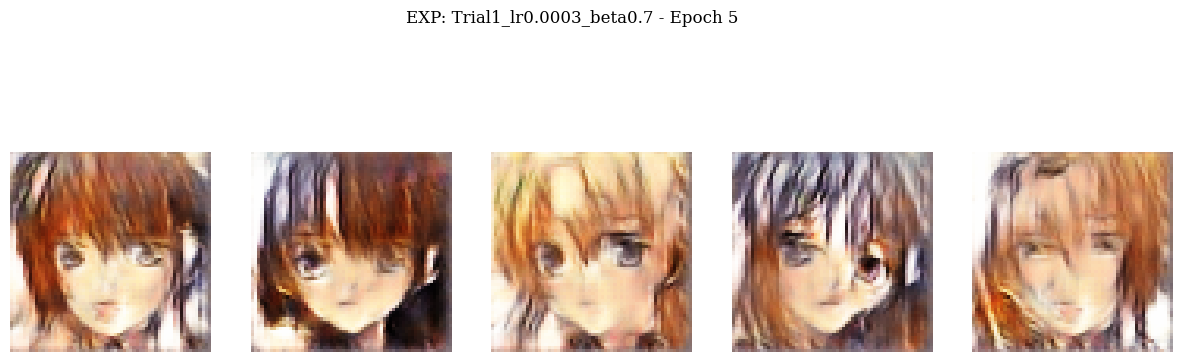

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3208 - g_loss: 2.4514
Epoch 6/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3115 - g_loss: 2.4241
Epoch 7/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3312 - g_loss: 2.2864
Epoch 8/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2570 - g_loss: 2.4770
Epoch 9/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2973 - g_loss: 2.3832
Epoch 10/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.2881 - g_loss: 2.5747

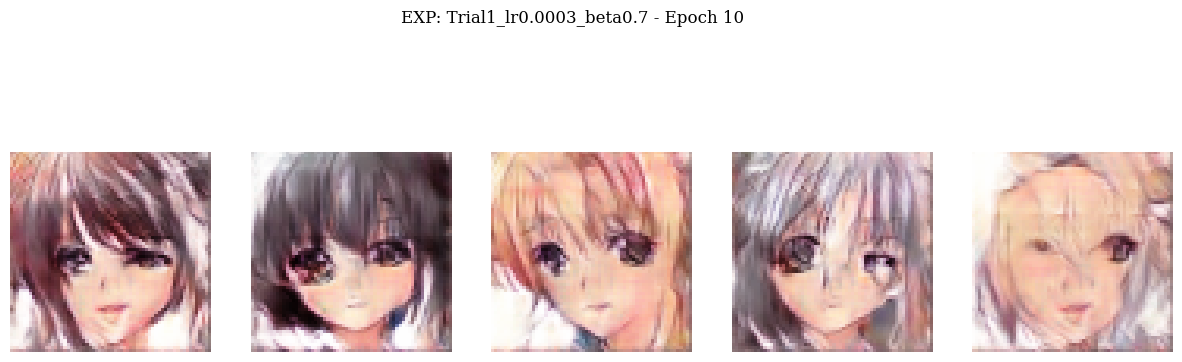

994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2880 - g_loss: 2.5748
Epoch 11/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2528 - g_loss: 2.5630
Epoch 12/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2229 - g_loss: 2.7591
Epoch 13/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2377 - g_loss: 2.7461
Epoch 14/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2832 - g_loss: 2.5378
Epoch 15/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.3834 - g_loss: 2.3374

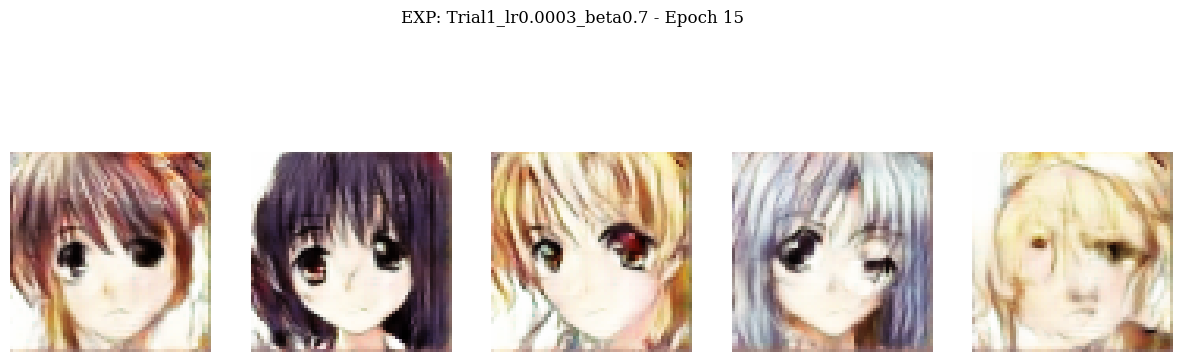

994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3832 - g_loss: 2.3376
Epoch 16/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2706 - g_loss: 2.6952
Epoch 17/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2673 - g_loss: 2.5063
Epoch 18/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2238 - g_loss: 2.7144
Epoch 19/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3425 - g_loss: 2.2685
Epoch 20/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.2158 - g_loss: 2.7344

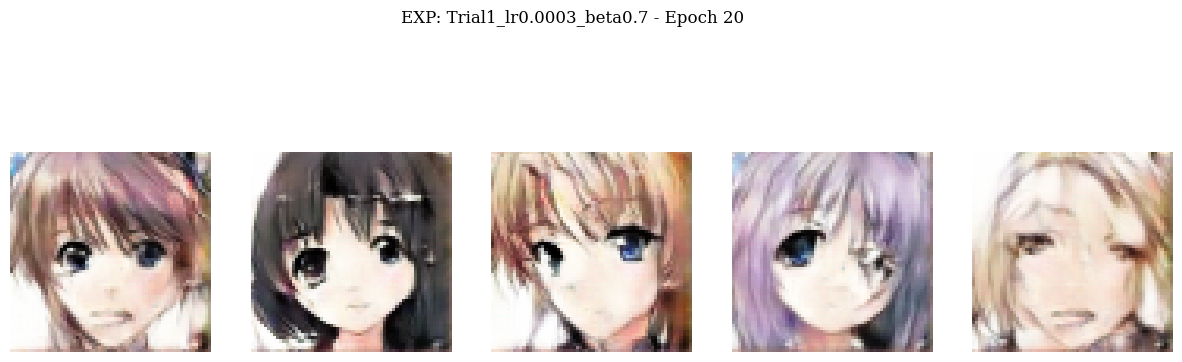

994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2158 - g_loss: 2.7344
Epoch 21/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2911 - g_loss: 2.4888
Epoch 22/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.3017 - g_loss: 2.5249
Epoch 23/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2576 - g_loss: 2.5910
Epoch 24/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2676 - g_loss: 2.5498
Epoch 25/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.2858 - g_loss: 2.6722

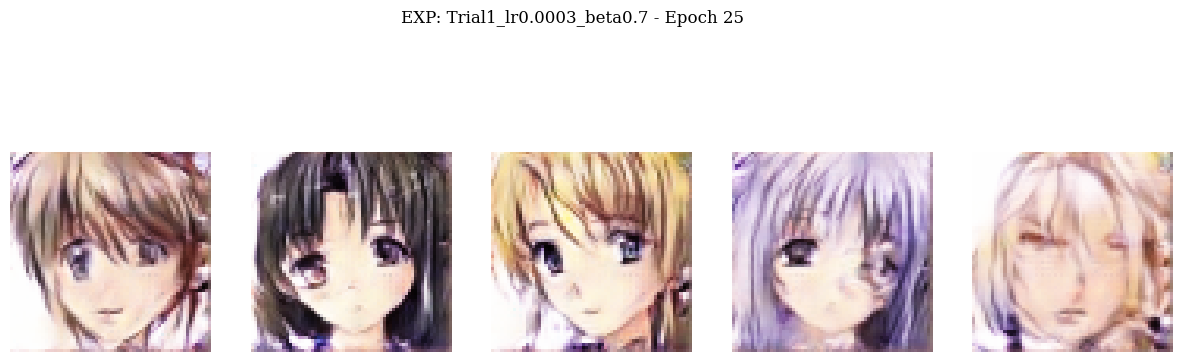

994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2858 - g_loss: 2.6717
Epoch 26/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2081 - g_loss: 2.8387
Epoch 27/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2205 - g_loss: 2.7644
Epoch 28/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2810 - g_loss: 2.7250
Epoch 29/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.1567 - g_loss: 2.9624
Epoch 30/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.2548 - g_loss: 2.7045

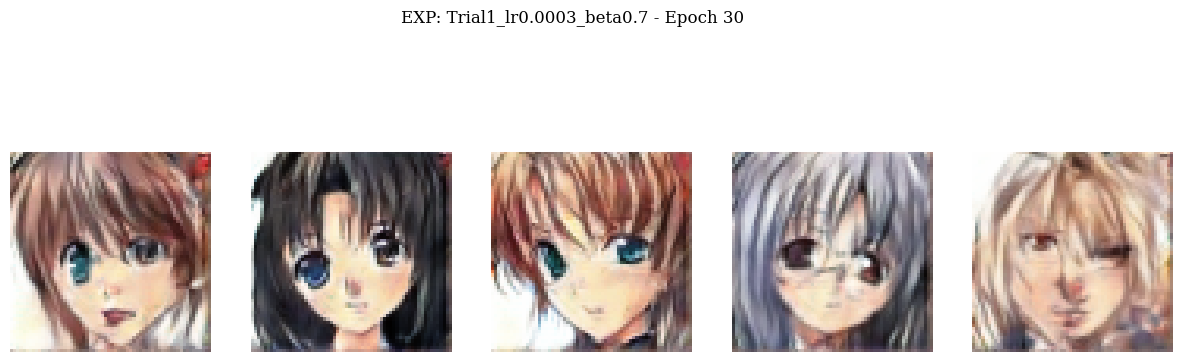

994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - d_loss: 0.2548 - g_loss: 2.7046

 Menjalankan Eksperimen 2/5: Trial2_lr0.0003_beta0.4 
Epoch 1/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - d_loss: 0.4663 - g_loss: 1.6245
Epoch 2/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4426 - g_loss: 1.8897
Epoch 3/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4370 - g_loss: 1.7813
Epoch 4/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4029 - g_loss: 1.8303
Epoch 5/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.3708 - g_loss: 1.9329

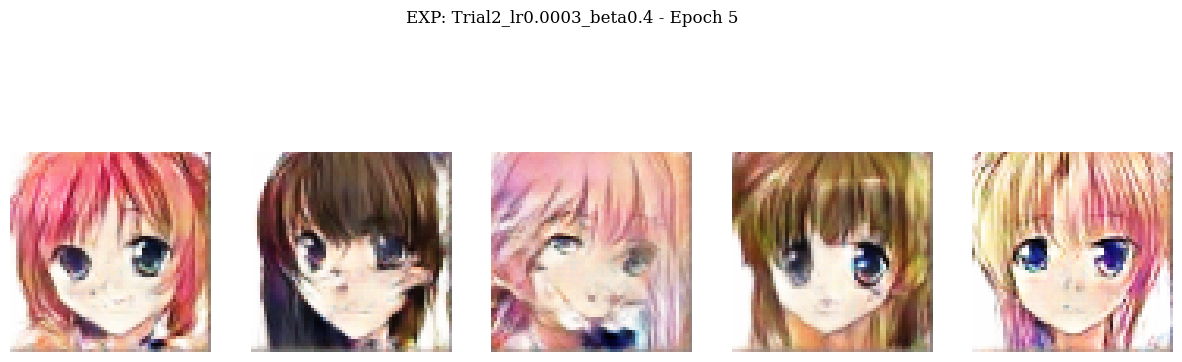

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3708 - g_loss: 1.9329
Epoch 6/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3411 - g_loss: 2.0324
Epoch 7/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3279 - g_loss: 2.0936
Epoch 8/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3154 - g_loss: 2.1072
Epoch 9/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3089 - g_loss: 2.1529
Epoch 10/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.2890 - g_loss: 2.2394

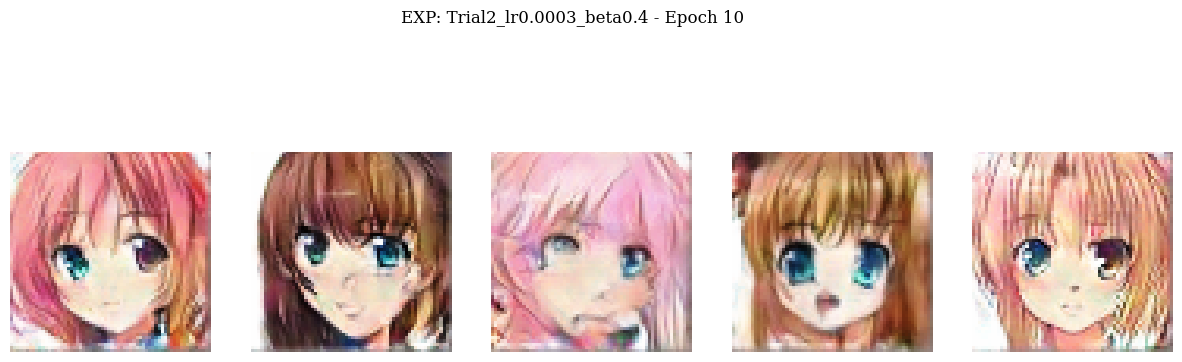

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.2890 - g_loss: 2.2393
Epoch 11/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2798 - g_loss: 2.3077
Epoch 12/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2692 - g_loss: 2.3165
Epoch 13/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2810 - g_loss: 2.2986
Epoch 14/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2514 - g_loss: 2.4403
Epoch 15/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.2533 - g_loss: 2.5260

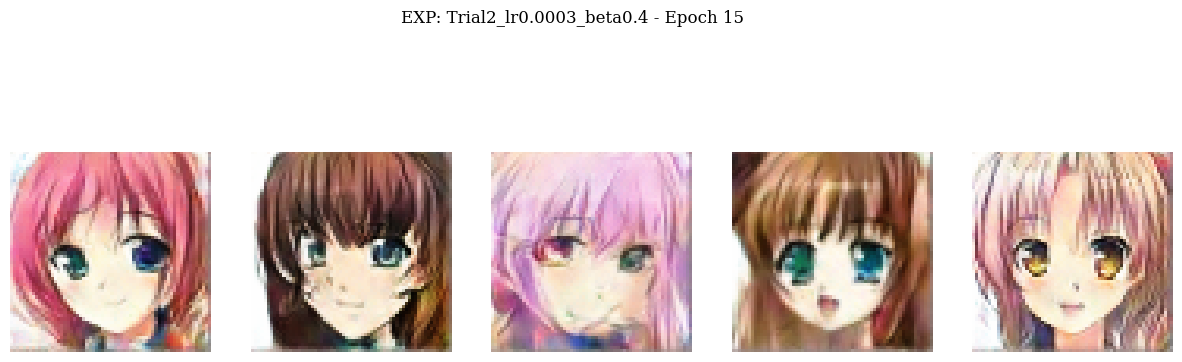

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2533 - g_loss: 2.5261
Epoch 16/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.2213 - g_loss: 2.5964
Epoch 17/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.2451 - g_loss: 2.5603
Epoch 18/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.2185 - g_loss: 2.7376
Epoch 19/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1999 - g_loss: 2.8293
Epoch 20/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.1545 - g_loss: 2.9915

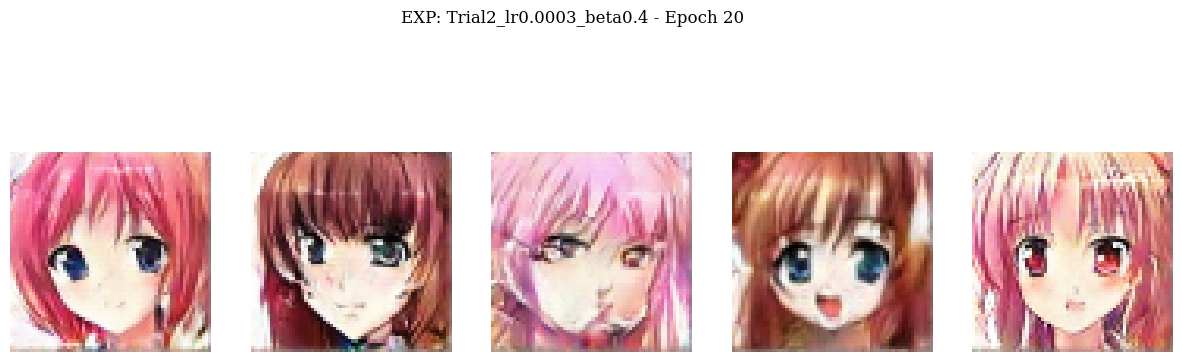

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.1545 - g_loss: 2.9913
Epoch 21/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1802 - g_loss: 2.9853
Epoch 22/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1907 - g_loss: 3.0314
Epoch 23/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1372 - g_loss: 3.1444
Epoch 24/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1168 - g_loss: 3.2756
Epoch 25/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.1558 - g_loss: 3.1849

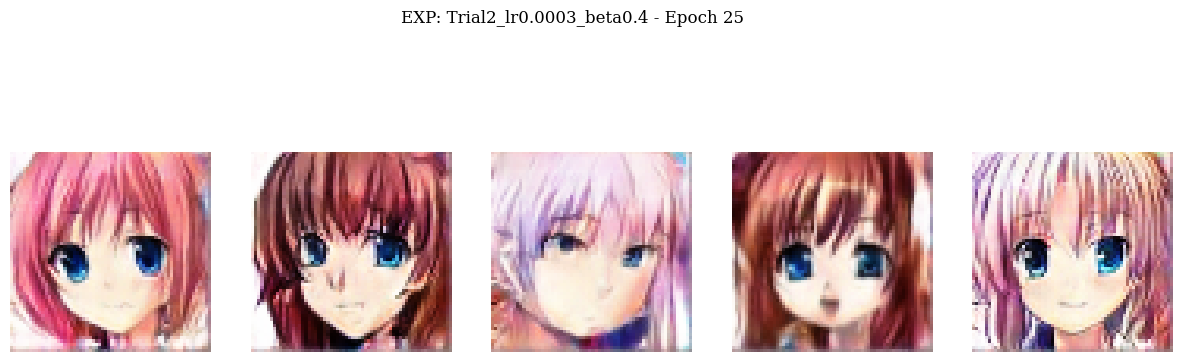

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.1560 - g_loss: 3.1844
Epoch 26/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.0833 - g_loss: 3.3321
Epoch 27/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.0624 - g_loss: 3.4320
Epoch 28/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.0789 - g_loss: 3.2902
Epoch 29/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.0349 - g_loss: 3.6168
Epoch 30/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.1470 - g_loss: 2.8926

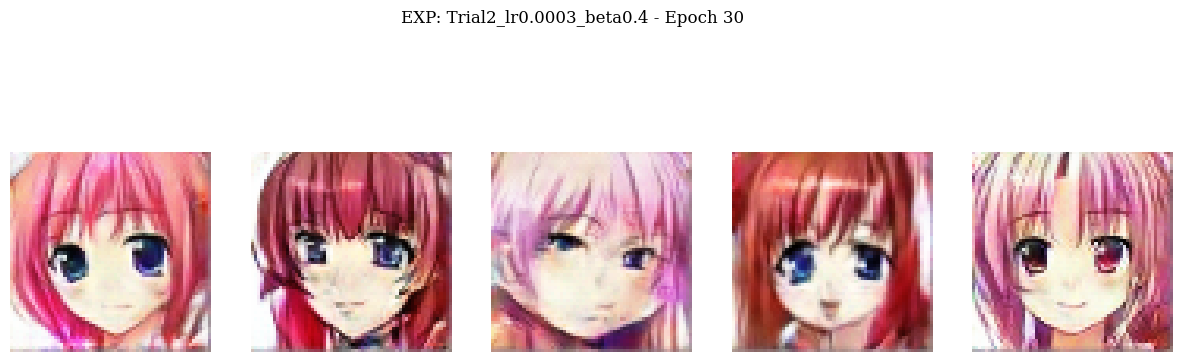

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.1467 - g_loss: 2.8934

 Menjalankan Eksperimen 3/5: Trial3_lr0.0001_beta0.9 
Epoch 1/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 153s 145ms/step - d_loss: 0.2022 - g_loss: 4.2680
Epoch 2/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.4109 - g_loss: 1.6832
Epoch 3/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.4014 - g_loss: 1.9313
Epoch 4/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3409 - g_loss: 2.0073
Epoch 5/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.4149 - g_loss: 1.9528

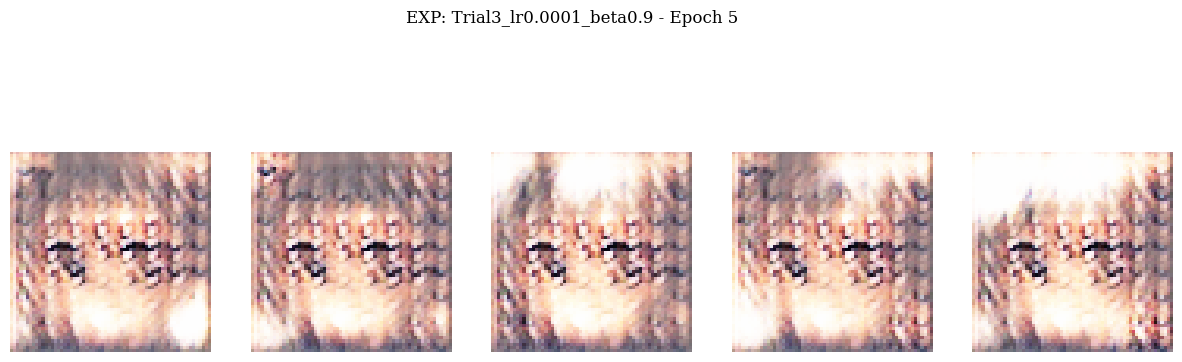

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.4148 - g_loss: 1.9530
Epoch 6/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3952 - g_loss: 1.9754
Epoch 7/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.4516 - g_loss: 1.9652
Epoch 8/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3562 - g_loss: 2.0813
Epoch 9/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3655 - g_loss: 2.1033
Epoch 10/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.3237 - g_loss: 2.5207

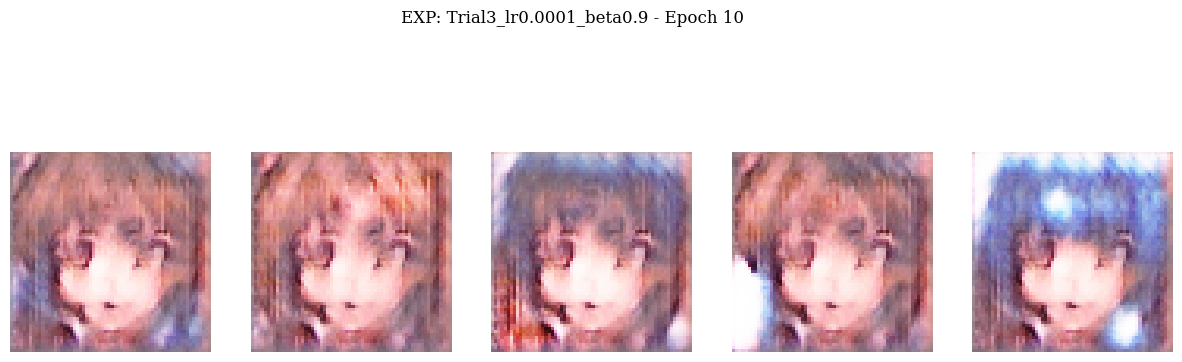

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3236 - g_loss: 2.5206
Epoch 11/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3267 - g_loss: 2.6490
Epoch 12/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.2648 - g_loss: 2.6242
Epoch 13/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - d_loss: 0.2704 - g_loss: 3.3099
Epoch 14/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - d_loss: 0.2383 - g_loss: 2.7952
Epoch 15/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - d_loss: 0.2545 - g_loss: 2.9270

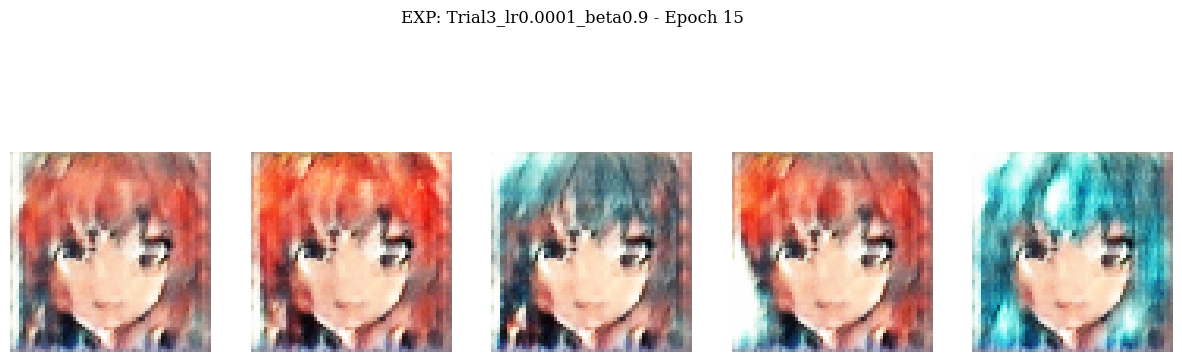

994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - d_loss: 0.2544 - g_loss: 2.9266
Epoch 16/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - d_loss: 0.2290 - g_loss: 3.3704
Epoch 17/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3300 - g_loss: 3.4600
Epoch 18/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - d_loss: -139.9931 - g_loss: 33.0301
Epoch 19/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 134s 135ms/step - d_loss: 141256.9688 - g_loss: 57735.4766
Epoch 20/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - d_loss: -59.9114 - g_loss: 305.8791

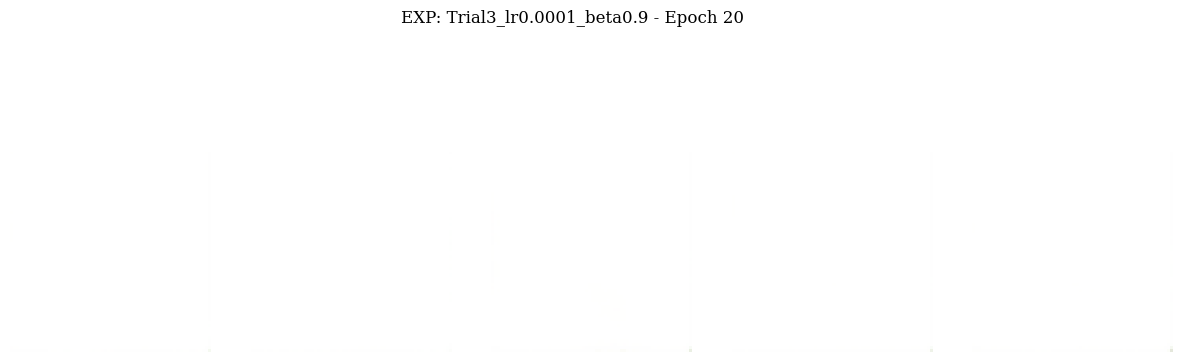

994/994 ━━━━━━━━━━━━━━━━━━━━ 134s 135ms/step - d_loss: -59.9830 - g_loss: 306.0943
Epoch 21/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 134s 135ms/step - d_loss: -317.6183 - g_loss: 610.0856
Epoch 22/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 134s 135ms/step - d_loss: -2568.9705 - g_loss: 8659.4297
Epoch 23/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - d_loss: -10949.3457 - g_loss: 88813.5000
Epoch 24/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 24850.4805 - g_loss: 176468.0000
Epoch 25/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - d_loss: 145923.0469 - g_loss: 1866.7449

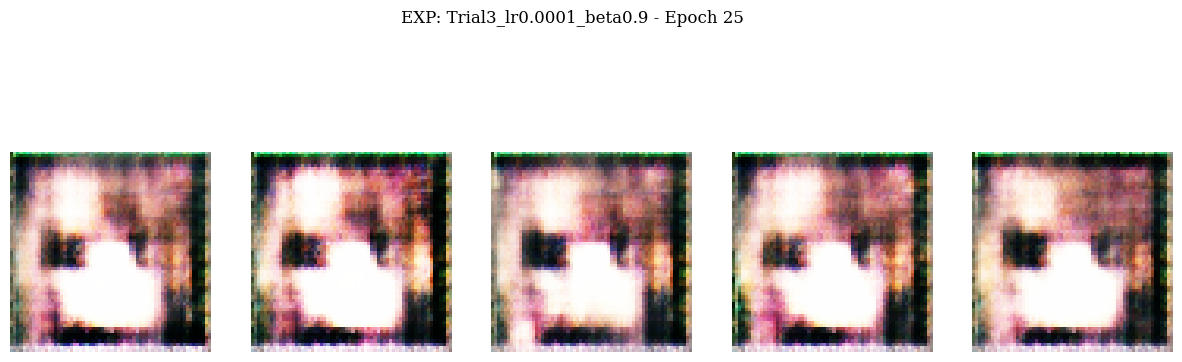

994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 145845.8281 - g_loss: 1865.5079
Epoch 26/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 38075.4883 - g_loss: 790.7719
Epoch 27/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 13703.8027 - g_loss: 288.1836
Epoch 28/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 7985.9473 - g_loss: 334.3211
Epoch 29/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 4980.6948 - g_loss: 448.4352
Epoch 30/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - d_loss: 3223.1819 - g_loss: 314.3806

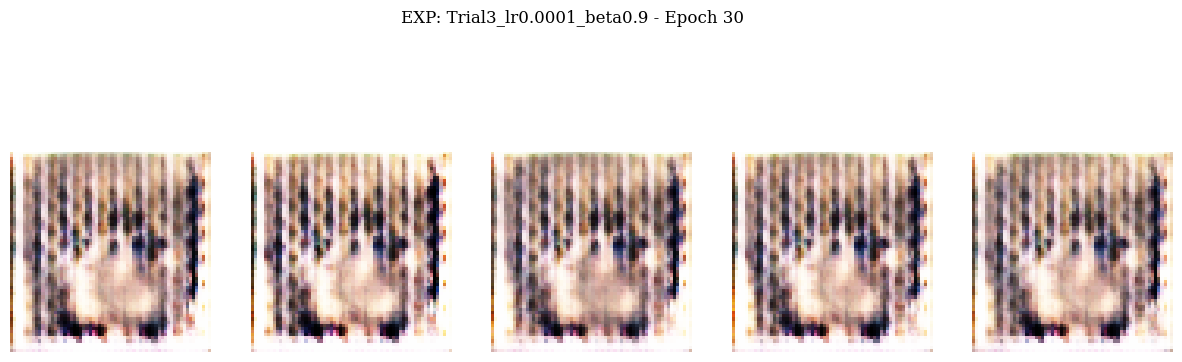

994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - d_loss: 3223.1851 - g_loss: 314.2909

 Menjalankan Eksperimen 4/5: Trial4_lr0.0001_beta0.7 
Epoch 1/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - d_loss: 0.3180 - g_loss: 2.0487
Epoch 2/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4347 - g_loss: 1.5229
Epoch 3/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4309 - g_loss: 1.6590
Epoch 4/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3946 - g_loss: 1.7812
Epoch 5/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3460 - g_loss: 2.0486

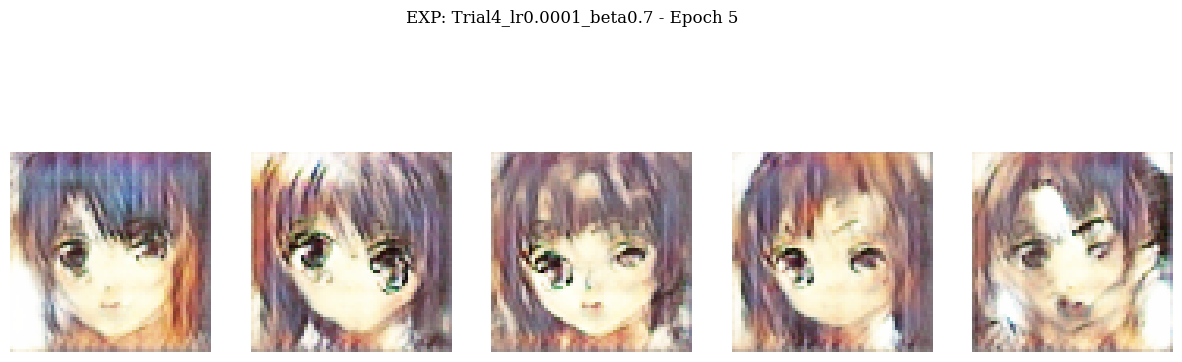

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3460 - g_loss: 2.0487
Epoch 6/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3206 - g_loss: 2.2050
Epoch 7/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3500 - g_loss: 1.9914
Epoch 8/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3896 - g_loss: 1.8682
Epoch 9/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3862 - g_loss: 1.7996
Epoch 10/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.4010 - g_loss: 1.7363

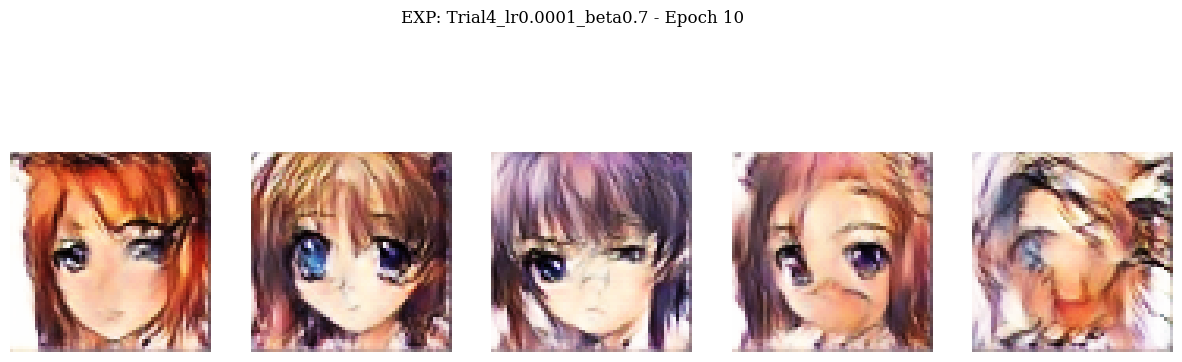

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.4010 - g_loss: 1.7363
Epoch 11/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3908 - g_loss: 1.7135
Epoch 12/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3904 - g_loss: 1.8085
Epoch 13/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3748 - g_loss: 1.7898
Epoch 14/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 140s 141ms/step - d_loss: 0.3692 - g_loss: 1.7717
Epoch 15/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.3739 - g_loss: 1.7378

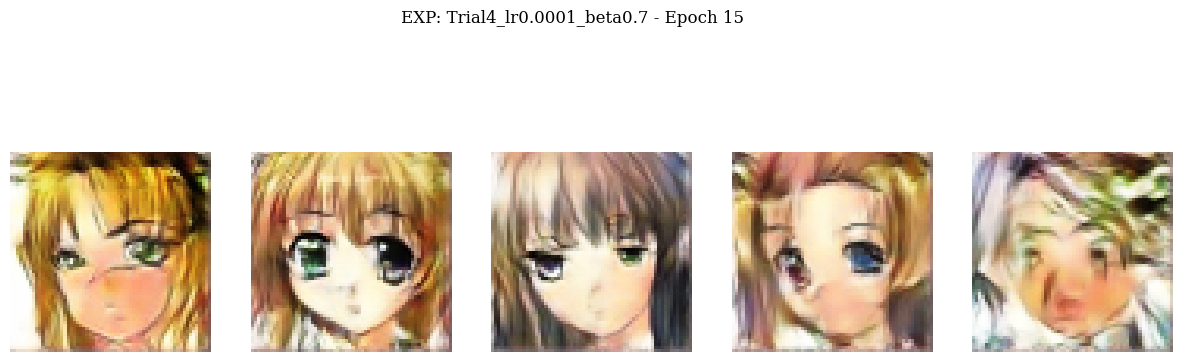

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3739 - g_loss: 1.7378
Epoch 16/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3768 - g_loss: 1.7521
Epoch 17/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3719 - g_loss: 1.7565
Epoch 18/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3710 - g_loss: 1.7820
Epoch 19/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3804 - g_loss: 1.7768
Epoch 20/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.3649 - g_loss: 1.7606

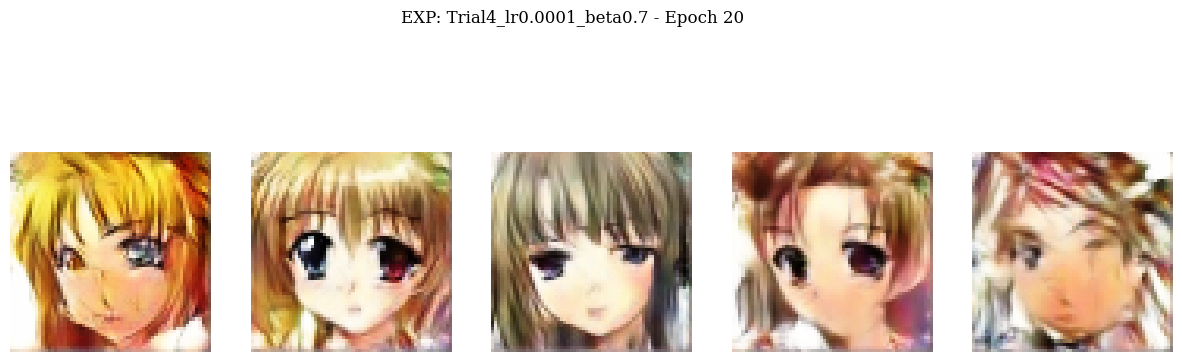

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3649 - g_loss: 1.7606
Epoch 21/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3676 - g_loss: 1.7842
Epoch 22/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3624 - g_loss: 1.7807
Epoch 23/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3645 - g_loss: 1.7995
Epoch 24/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3579 - g_loss: 1.8035
Epoch 25/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3521 - g_loss: 1.8179

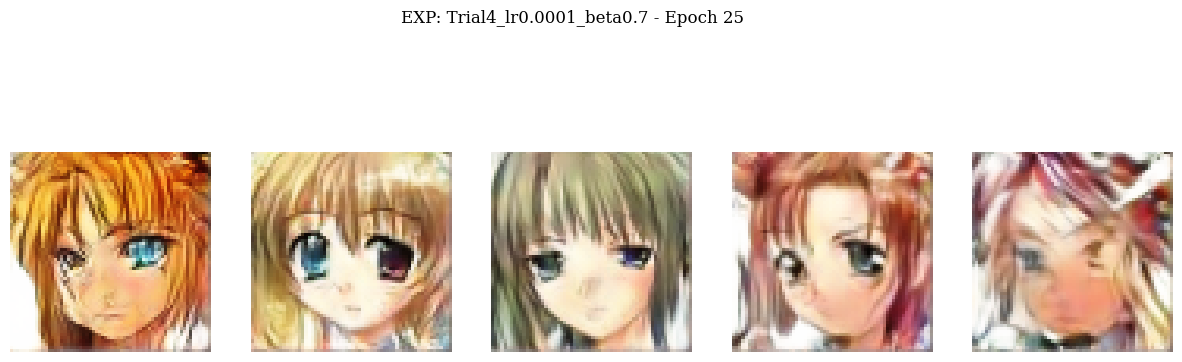

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3521 - g_loss: 1.8179
Epoch 26/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3434 - g_loss: 1.8759
Epoch 27/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3290 - g_loss: 1.8874
Epoch 28/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3313 - g_loss: 1.9416
Epoch 29/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3301 - g_loss: 1.9677
Epoch 30/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3230 - g_loss: 1.9456

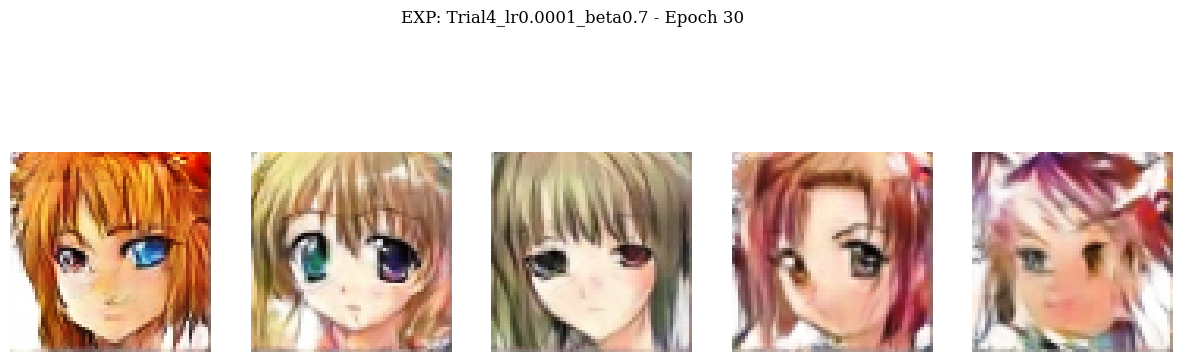

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3230 - g_loss: 1.9457

 Menjalankan Eksperimen 5/5: Trial5_lr0.0001_beta0.7 
Epoch 1/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - d_loss: 0.2885 - g_loss: 2.3408
Epoch 2/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.4265 - g_loss: 1.6089
Epoch 3/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.4310 - g_loss: 1.6531
Epoch 4/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3779 - g_loss: 1.8204
Epoch 5/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3355 - g_loss: 2.1742

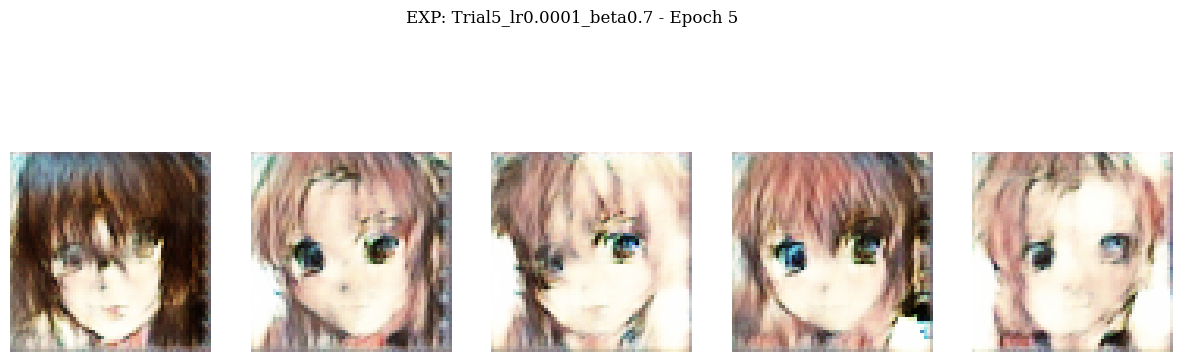

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3354 - g_loss: 2.1743
Epoch 6/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.2911 - g_loss: 2.2364
Epoch 7/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3264 - g_loss: 2.1263
Epoch 8/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3612 - g_loss: 1.9609
Epoch 9/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3737 - g_loss: 1.8289
Epoch 10/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3792 - g_loss: 1.8799

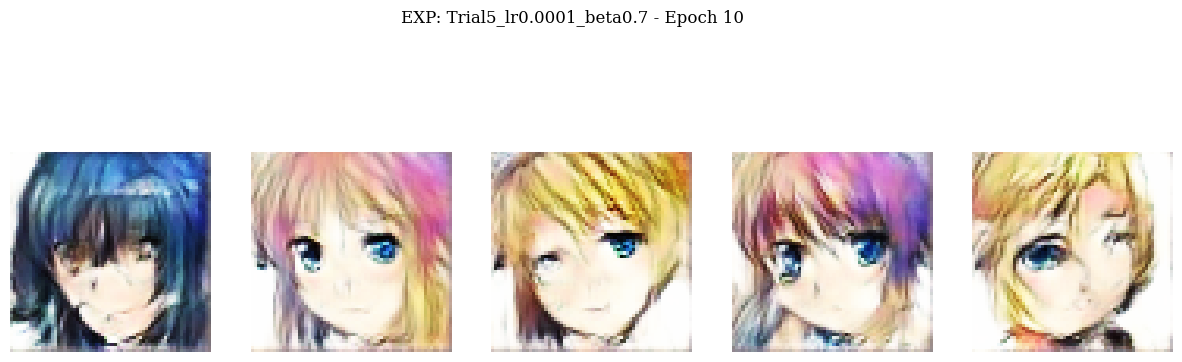

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3792 - g_loss: 1.8799
Epoch 11/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3651 - g_loss: 1.8733
Epoch 12/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3677 - g_loss: 1.8698
Epoch 13/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3503 - g_loss: 1.8590
Epoch 14/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3292 - g_loss: 1.9341
Epoch 15/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3350 - g_loss: 1.9440

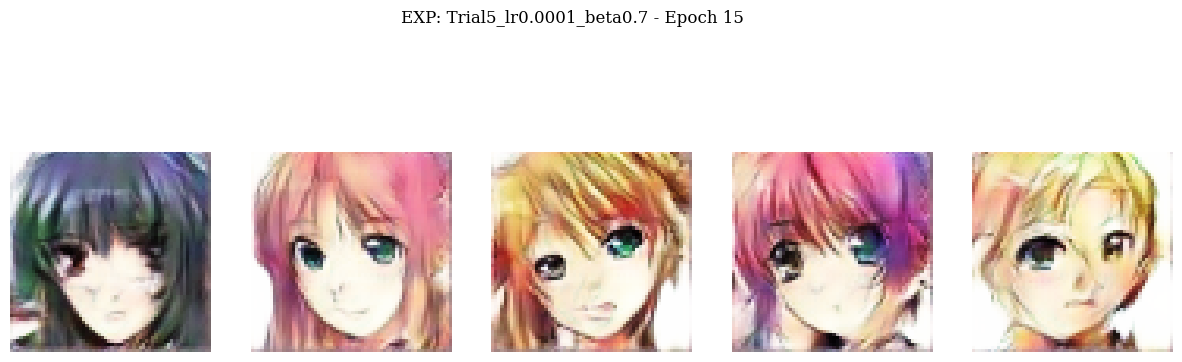

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3350 - g_loss: 1.9440
Epoch 16/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3302 - g_loss: 1.9548
Epoch 17/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3333 - g_loss: 1.9497
Epoch 18/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3356 - g_loss: 1.9415
Epoch 19/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3381 - g_loss: 1.9293
Epoch 20/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3386 - g_loss: 1.9157

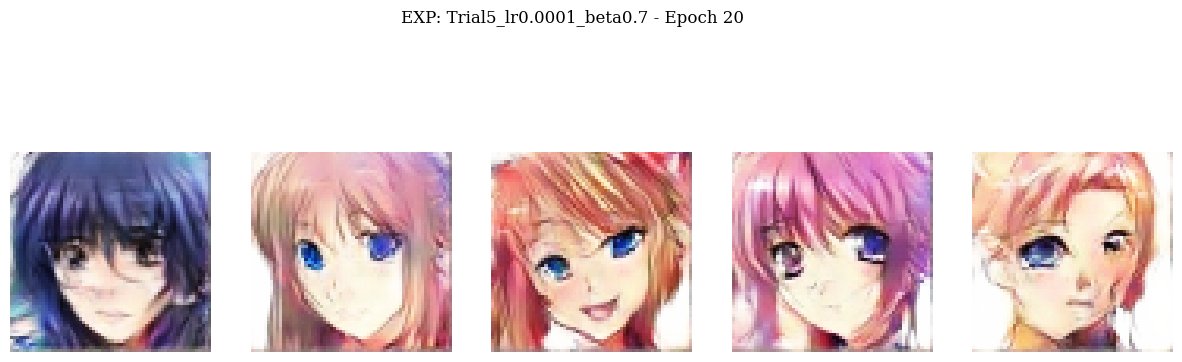

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3386 - g_loss: 1.9157
Epoch 21/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3356 - g_loss: 1.9260
Epoch 22/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3341 - g_loss: 1.8916
Epoch 23/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3317 - g_loss: 1.9333
Epoch 24/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3251 - g_loss: 1.9773
Epoch 25/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3225 - g_loss: 1.9630

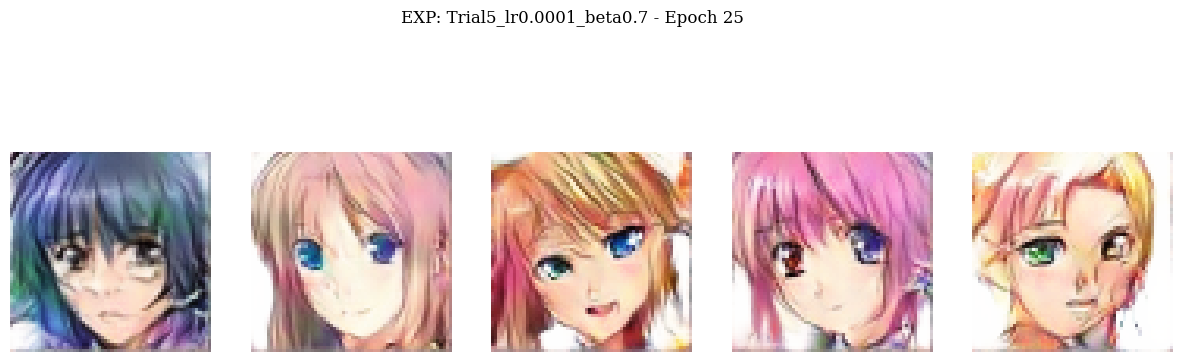

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3225 - g_loss: 1.9631
Epoch 26/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3158 - g_loss: 1.9853
Epoch 27/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3176 - g_loss: 1.9798
Epoch 28/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.3199 - g_loss: 2.0379
Epoch 29/30
994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - d_loss: 0.2985 - g_loss: 2.0397
Epoch 30/30
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.3111 - g_loss: 2.0460

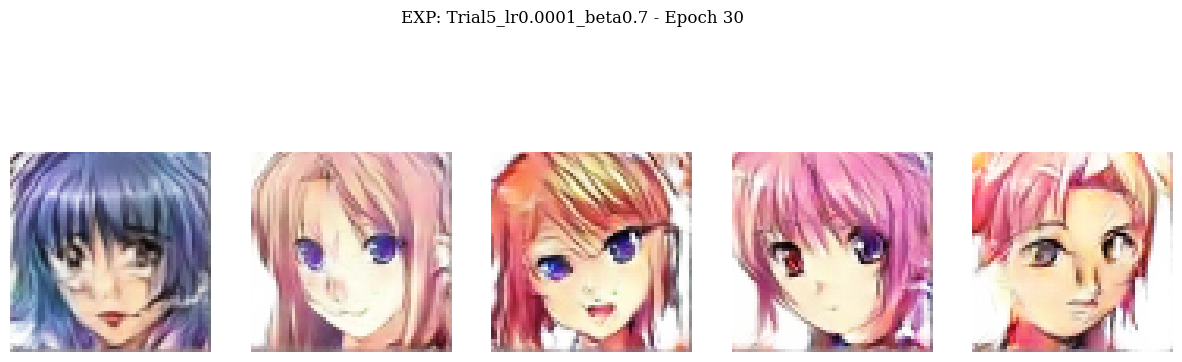

994/994 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - d_loss: 0.3110 - g_loss: 2.0461

 Random Search Selesai


In [ ]:
# setup daftar kandidat hyperparameter yang akan diuji
lr_choices = [0.0001, 0.0002, 0.0003, 0.0004, 0.00005]   # daftar kandidat learning rate
beta_1_choices = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]          # daftar kandidat beta_1 untuk optimizer adam

# tentukan batasan percobaan
NUM_TRIALS = 5  # jumlah percobaan acak yang akan dijalankan
EPOCHS = 30     # jumlah epoch yang digunakan untuk setiap percobaan

# list untuk menyimpan hasil tiap trial
results = []
print(f"Mulai Random Search {NUM_TRIALS} Trials...")

# loop untuk menjalankan beberapa trial random search
for trial in range(NUM_TRIALS):

    # random sampling
    # pilih satu kombinasi lr dan beta_1 secara acak dari daftar
    lr = random.choice(lr_choices)
    beta_1 = random.choice(beta_1_choices)

    # buat nama unik untuk setiap percobaan berdasarkan nomor trial dan kombinasi hyperparameter
    run_name = f"Trial{trial+1}_lr{lr}_beta{beta_1}"

    print(f"\n Menjalankan Eksperimen {trial+1}/{NUM_TRIALS}: {run_name} ")

    # 1. reset model (sangat penting)
    # build ulang generator dan discriminator agar bobot mulai dari kondisi awal (fresh)
    clean_generator = build_generator()
    clean_discriminator = build_discriminator()

    # 2. inisialisasi optimizer dengan kombinasi hyperparameter untuk trial ini
    g_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    d_optimizer = Adam(learning_rate=lr, beta_1=beta_1)
    loss_fn = BinaryCrossentropy()

    # 3. compile dcgan dengan optimizer dan loss yang sudah ditentukan
    dcgan = DCGAN(clean_generator, clean_discriminator, LATENT_DIM)
    dcgan.compile(g_optimizer, d_optimizer, loss_fn)

    # 4. training dcgan dengan dataset yang sudah disiapkan
    # run_name digunakan sebagai prefix di callback agar file model/gambar tersimpan terpisah per trial
    history = dcgan.fit(
        dataset,
        epochs=EPOCHS,
        callbacks=[GANMonitor(num_img=5, latent_dim=LATENT_DIM, prefix=run_name)],
        verbose=1  # ubah ke 0 jika ingin log training lebih ringkas
    )

    # 5. simpan hasil training untuk trial ini
    # menyimpan nilai loss terakhir dan history penuh untuk analisis stabilitas
    results.append({
        'run_name': run_name,
        'lr': lr,
        'beta_1': beta_1,
        'final_g_loss': history.history['g_loss'][-1],
        'final_d_loss': history.history['d_loss'][-1],
        'g_loss_history': history.history['g_loss'],  # simpan list lengkap loss generator per epoch
        'd_loss_history': history.history['d_loss']   # simpan list lengkap loss discriminator per epoch
    })

# --- hasil akhir ---
print("\n Random Search Selesai")

In [ ]:
# buat ringkasan sederhana hasil random search
summary_data = []
for res in results:
    summary_data.append({
        'run_name': res['run_name'],          # nama trial (berisi info lr dan beta_1)
        'lr': res['lr'],                      # learning rate yang dipakai di trial ini
        'beta_1': res['beta_1'],              # nilai beta_1 adam di trial ini
        'final_g_loss': res['final_g_loss'],  # nilai loss generator di epoch terakhir
        'final_d_loss': res['final_d_loss']   # nilai loss discriminator di epoch terakhir
    })

# konversi ringkasan ke dataframe agar mudah dibaca dan dianalisis
df_results = pd.DataFrame(summary_data)
print(df_results)

                  run_name      lr  beta_1  final_g_loss  final_d_loss
0  Trial1_lr0.0003_beta0.7  0.0003     0.7      2.725470      0.243234
1  Trial2_lr0.0003_beta0.4  0.0003     0.4      3.301110      0.025507
2  Trial3_lr0.0001_beta0.9  0.0001     0.9    269.739227   3224.771973
3  Trial4_lr0.0001_beta0.7  0.0001     0.7      1.983893      0.312851
4  Trial5_lr0.0001_beta0.7  0.0001     0.7      2.061505      0.303084


# Analisis Stabilitas Model & Pemilihan Model Terbaik

In [ ]:
print("\n Analisis Stabilitas Model ")

# inisialisasi nilai skor terbaik dengan tak hingga (semakin kecil semakin bagus)
best_score = float('inf')
# menyimpan nama model terbaik berdasarkan skor
best_model_name = None
# list untuk menyimpan log analisis tiap model
analysis_log = []

# loop untuk setiap hasil trial yang tersimpan di results
for res in results:
    # konversi history loss generator dan discriminator ke numpy array
    g_hist = np.array(res['g_loss_history'])
    d_hist = np.array(res['d_loss_history'])

    # 1. cek tren menurun (slope)
    # bandingkan rata-rata 5 epoch awal vs 5 epoch akhir
    # jika (awal - akhir) > 0, berarti loss cenderung menurun (good)
    g_decrease = np.mean(g_hist[:5]) - np.mean(g_hist[-5:])
    d_decrease = np.mean(d_hist[:5]) - np.mean(d_hist[-5:])

    # true jika keduanya (g dan d) sama-sama mengalami penurunan
    is_decreasing = (g_decrease > 0) and (d_decrease > 0)

    # 2. cek stabilitas (standard deviation di 5 epoch terakhir)
    # semakin kecil std dev, semakin stabil (garis loss lebih tenang di akhir)
    g_stability = np.std(g_hist[-5:])
    d_stability = np.std(d_hist[-5:])

    # 3. cek keseimbangan (gap antara loss g dan d)
    # kita ingin g dan d bersaing ketat, jadi gap loss-nya jangan terlalu jauh
    final_gap = abs(np.mean(g_hist[-5:]) - np.mean(d_hist[-5:]))

    # skoring
    # membuat skor komposit (semakin kecil semakin baik)
    # bobot bisa disesuaikan, di sini stabilitas lebih diutamakan
    # jika tidak decreasing, diberi penalti besar (+1000)
    penalty = 0 if is_decreasing else 1000

    # score = (stabilitas g + stabilitas d) + (gap g vs d * 0.5) + penalti
    score = (g_stability + d_stability) + (final_gap * 0.5) + penalty

    # simpan hasil analisis untuk model ini ke dalam log
    analysis_log.append({
        'name': res['run_name'],
        'decreasing': is_decreasing,
        'stability_score': (g_stability + d_stability),
        'gap': final_gap,
        'total_score': score
    })

    # tampilkan ringkasan analisis untuk setiap model
    print(
        f"model: {res['run_name']} | "
        f"decreasing: {is_decreasing} | "
        f"stability (std): {g_stability + d_stability:.4f} | "
        f"final gap: {final_gap:.4f}"
    )

    # update model terbaik jika skor sekarang lebih kecil dari best_score sebelumnya
    if score < best_score:
        best_score = score
        best_model_name = res['run_name']

# --- keputusan ---
print(f"\n Rekomendasi Model Terbaik: {best_model_name}")
print("Alasan: Memiliki kombinasi stabilitas terbaik dan tren loss yang konvergen.")


 Analisis Stabilitas Model 
model: Trial1_lr0.0003_beta0.7 | decreasing: False | stability (std): 0.1032 | final gap: 2.5298
model: Trial2_lr0.0003_beta0.4 | decreasing: False | stability (std): 0.1121 | final gap: 3.2628
model: Trial3_lr0.0001_beta0.9 | decreasing: False | stability (std): 9287.9144 | final gap: 10936.0055
model: Trial4_lr0.0001_beta0.7 | decreasing: False | stability (std): 0.0496 | final gap: 1.6090
model: Trial5_lr0.0001_beta0.7 | decreasing: False | stability (std): 0.0330 | final gap: 1.7174

 Rekomendasi Model Terbaik: Trial4_lr0.0001_beta0.7
Alasan: Memiliki kombinasi stabilitas terbaik dan tren loss yang konvergen.


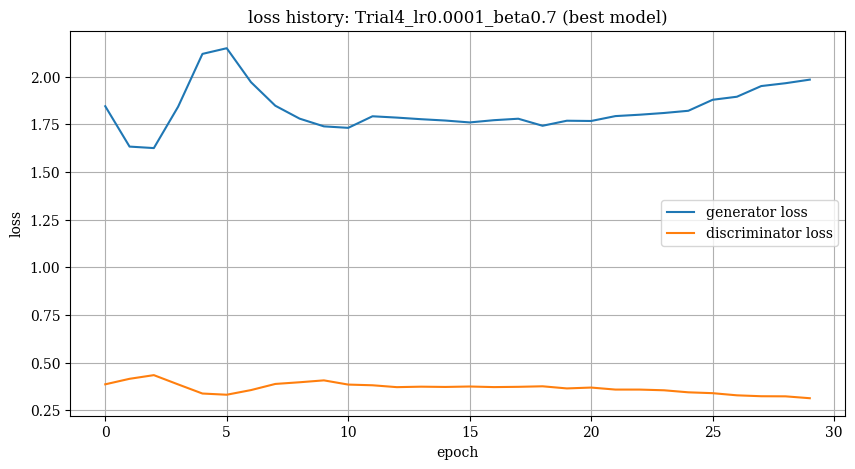

In [ ]:
# visualisasi grafik loss model terbaik
# cari data model terbaik berdasarkan nama run
best_run_data = next(item for item in results if item["run_name"] == best_model_name)

plt.figure(figsize=(10, 5))
plt.plot(best_run_data['g_loss_history'], label='generator loss')
plt.plot(best_run_data['d_loss_history'], label='discriminator loss')
plt.title(f"loss history: {best_model_name} (best model)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

# Generate 10 Wajah Anime Baru

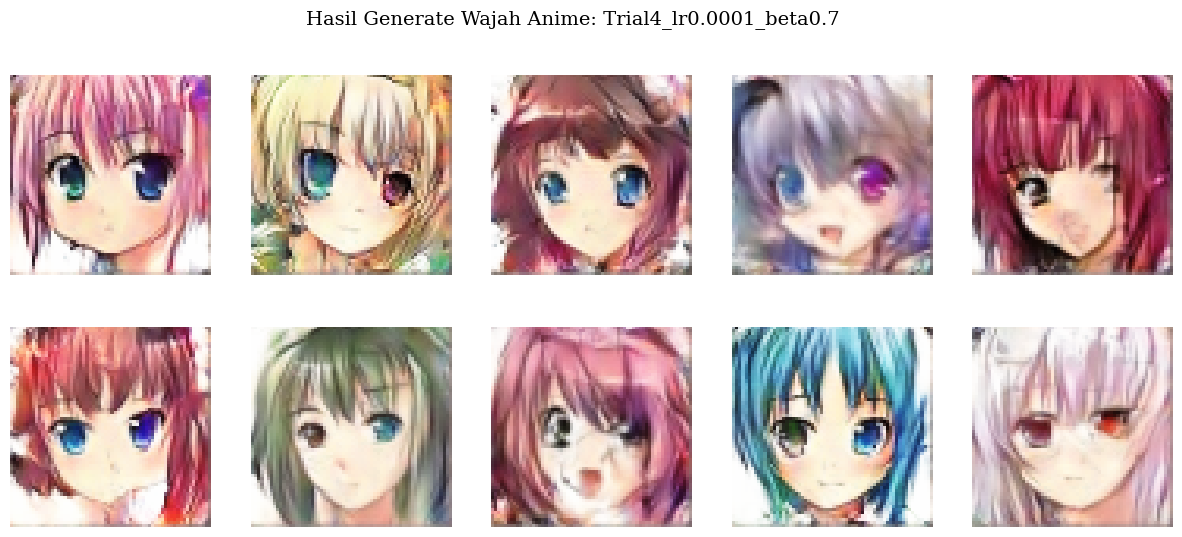

In [ ]:
# generate dan tampilkan 10 wajah anime baru dari model terbaik
# load kembali generator terbaik dari file yang sudah disimpan
best_generator_path = f"Generator_{best_model_name}.h5"
best_generator = tf.keras.models.load_model(best_generator_path)

# buat noise acak sebagai input generator
num_samples = 10                        # jumlah gambar yang ingin ditampilkan
z = tf.random.normal([num_samples, LATENT_DIM])

# generate gambar dari noise
generated_images = best_generator(z)
generated_images = generated_images.numpy()

# jika output generator di [0, 1], tidak perlu transformasi tambahan
# jika kamu pakai tanh dan [-1, 1], tambahkan baris:
# generated_images = (generated_images + 1.0) * 0.5

# tampilkan dalam grid 2x5
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    img = np.clip(generated_images[i], 0.0, 1.0)  # memastikan nilai tetap di range valid
    plt.imshow(img)
    plt.axis("off")

plt.suptitle(f"Hasil Generate Wajah Anime: {best_model_name}", fontsize=14)
plt.show()